## Lab 5 - Using link functions to create generalized linear models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('airline_data.csv')
df

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0
5,1981,21,362,6033.0
6,1982,26,764,5877.0
7,1983,20,809,6223.0
8,1984,16,223,7433.0
9,1985,22,1066,7107.0


In [3]:
df.describe()

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000
std,3.02765,4.709329,252.389228,1117.767795
min,1976.00000,16.000000,223.000000,3863.000000
25%,1978.25000,21.250000,570.500000,5140.500000
50%,1980.50000,23.000000,759.000000,5845.500000
75%,1982.75000,25.750000,812.750000,6175.500000
max,1985.00000,31.000000,1066.000000,7433.000000


In [4]:
df['Miles flown [100 mln miles]'] /= 1000
df

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3.863
1,1977,25,516,4.300
2,1978,31,754,5.027
3,1979,31,877,5.481
4,1980,22,814,5.814
5,1981,21,362,6.033
6,1982,26,764,5.877
7,1983,20,809,6.223
8,1984,16,223,7.433
9,1985,22,1066,7.107


In [5]:
df['Miles centered'] = df['Miles flown [100 mln miles]'] - df['Miles flown [100 mln miles]'].mean()
df['Miles centered'].describe()

count    1.000000e+01
mean     1.776357e-16
std      1.117768e+00
min     -1.852800e+00
25%     -5.753000e-01
50%      1.297000e-01
75%      4.597000e-01
max      1.717200e+00
Name: Miles centered, dtype: float64

In [6]:
upper_bound = 50
lower_bound = 10

n_max = df['Miles centered'].max()
n_min = df['Miles centered'].min()

theta = (np.log(upper_bound) - np.log(lower_bound)) / (n_max - n_min)
alpha = np.log(lower_bound) - theta * n_min

print(f"{theta=:.4f}\n{alpha=:.4f}")

theta=0.4508
alpha=3.1379


### Prior predictive distribution

In [8]:
model_1 = CmdStanModel(stan_file="code_1.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [9]:
R = 1000
sample=model_1.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,
                     refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [10]:
accidents = sample.draws_pd().accidents.values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


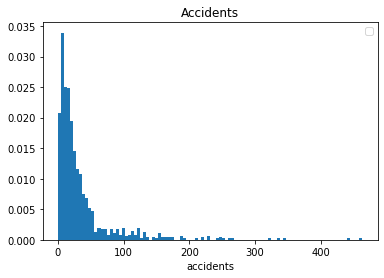

In [11]:
plt.hist(accidents, density=True, bins=100)
plt.title('Accidents')
plt.xlabel('accidents')
plt.legend()
plt.show()

### Posterior predictive distribution

In [12]:
model_2 = CmdStanModel(stan_file='code_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [13]:
data_fit = {'N': len(df), 'miles': df['Miles centered'].values, 'accidents': df['Fatal accidents'].values}
fit = model_2.sample(data=data_fit, seed=15042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [14]:
fit_df = fit.draws_pd()
fit_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,theta,lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],lambda[6],lambda[7],lambda[8],lambda[9],lambda[10]
0,511.952,0.992241,0.994404,1.0,3.0,0.0,-511.355,3.16988,-0.018742,24.6457,24.4447,24.1139,23.9096,23.7608,23.6635,23.7328,23.5794,23.0507,23.1920
1,511.880,0.845742,0.994404,2.0,3.0,0.0,-510.837,3.15012,-0.008717,23.7188,23.6286,23.4794,23.3866,23.3189,23.2744,23.3060,23.2359,22.9921,23.0575
2,511.539,0.952048,0.994404,2.0,3.0,0.0,-511.530,3.18673,-0.071500,27.6383,26.7881,25.4312,24.6190,24.0397,23.6662,23.9317,23.3469,21.4120,21.9169
3,511.577,0.969425,0.994404,2.0,3.0,0.0,-511.049,3.22241,-0.009186,25.5192,25.4170,25.2478,25.1428,25.0660,25.0156,25.0515,24.9720,24.6959,24.7700
4,511.097,0.889576,0.994404,1.0,1.0,0.0,-511.078,3.25045,-0.006677,26.1231,26.0470,25.9209,25.8424,25.7850,25.7473,25.7742,25.7147,25.5078,25.5634


In [15]:
years = df['Year'].values
observed_lambda = df['Fatal accidents'].values
sampled_lambdas = fit_df.loc[:, "lambda[1]":"lambda[10]"]

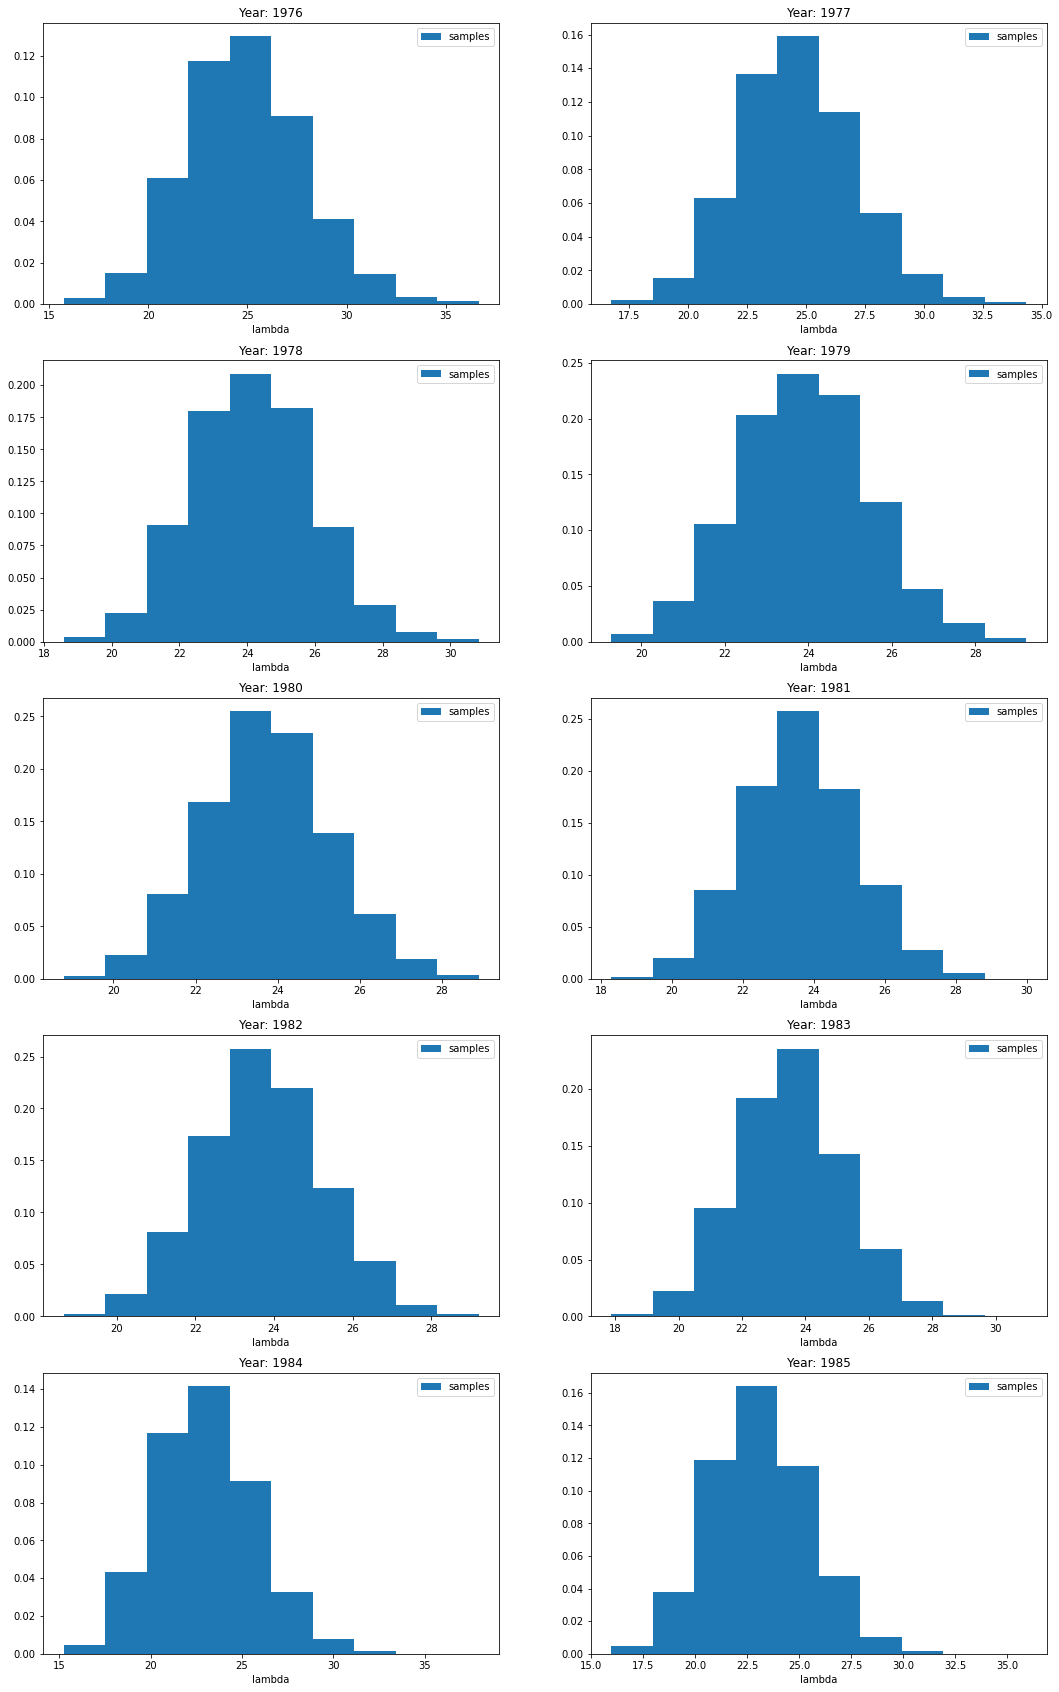

In [16]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(18, 30))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'lambda[{i + 1}]'].values, density=True, label='samples')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {years[i]}')
    ax.legend()

### Posterior predictive distribution for each year

In [17]:
model_3 = CmdStanModel(stan_file='code_3.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [18]:
fit_2 = model_3.sample(data=data_fit, seed=15042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [19]:
fit_2_df = fit_2.draws_pd()
fit_2_df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],lambda[6],lambda[7],lambda[8],lambda[9],lambda[10]
0,514.238,0.948757,0.438493,3.0,7.0,0.0,-506.827,3.86637,3.95448,3.85231,...,21.5442,28.3894,35.0330,36.4576,22.2572,18.1008,19.5961,26.3495,22.9549,24.7667
1,513.451,0.961482,0.438493,3.0,15.0,0.0,-509.012,4.25582,3.85919,3.71604,...,23.5772,20.5333,27.3513,25.5359,24.2596,24.3681,20.8243,21.2778,10.3886,22.2827
2,512.678,0.923482,0.438493,3.0,7.0,0.0,-506.915,4.01467,3.93476,3.96098,...,19.3821,22.9237,35.5347,34.3198,22.2358,19.8271,28.2792,16.8010,8.6395,22.0012
3,514.965,0.883326,0.438493,4.0,15.0,0.0,-507.102,4.14873,4.08278,3.63542,...,28.7629,32.4396,28.2718,27.0707,21.0166,18.3886,22.5633,21.9420,21.9432,19.1794
4,512.641,0.926606,0.438493,3.0,7.0,0.0,-508.995,3.79062,3.59338,3.56089,...,19.6114,19.5111,25.9996,29.1224,23.6891,15.7783,35.0392,22.5784,10.0291,25.1821


In [20]:
years = df['Year'].values
observed_lambda = df['Fatal accidents'].values
sampled_lambdas = fit_2_df.loc[:, "lambda[1]":"lambda[10]"]

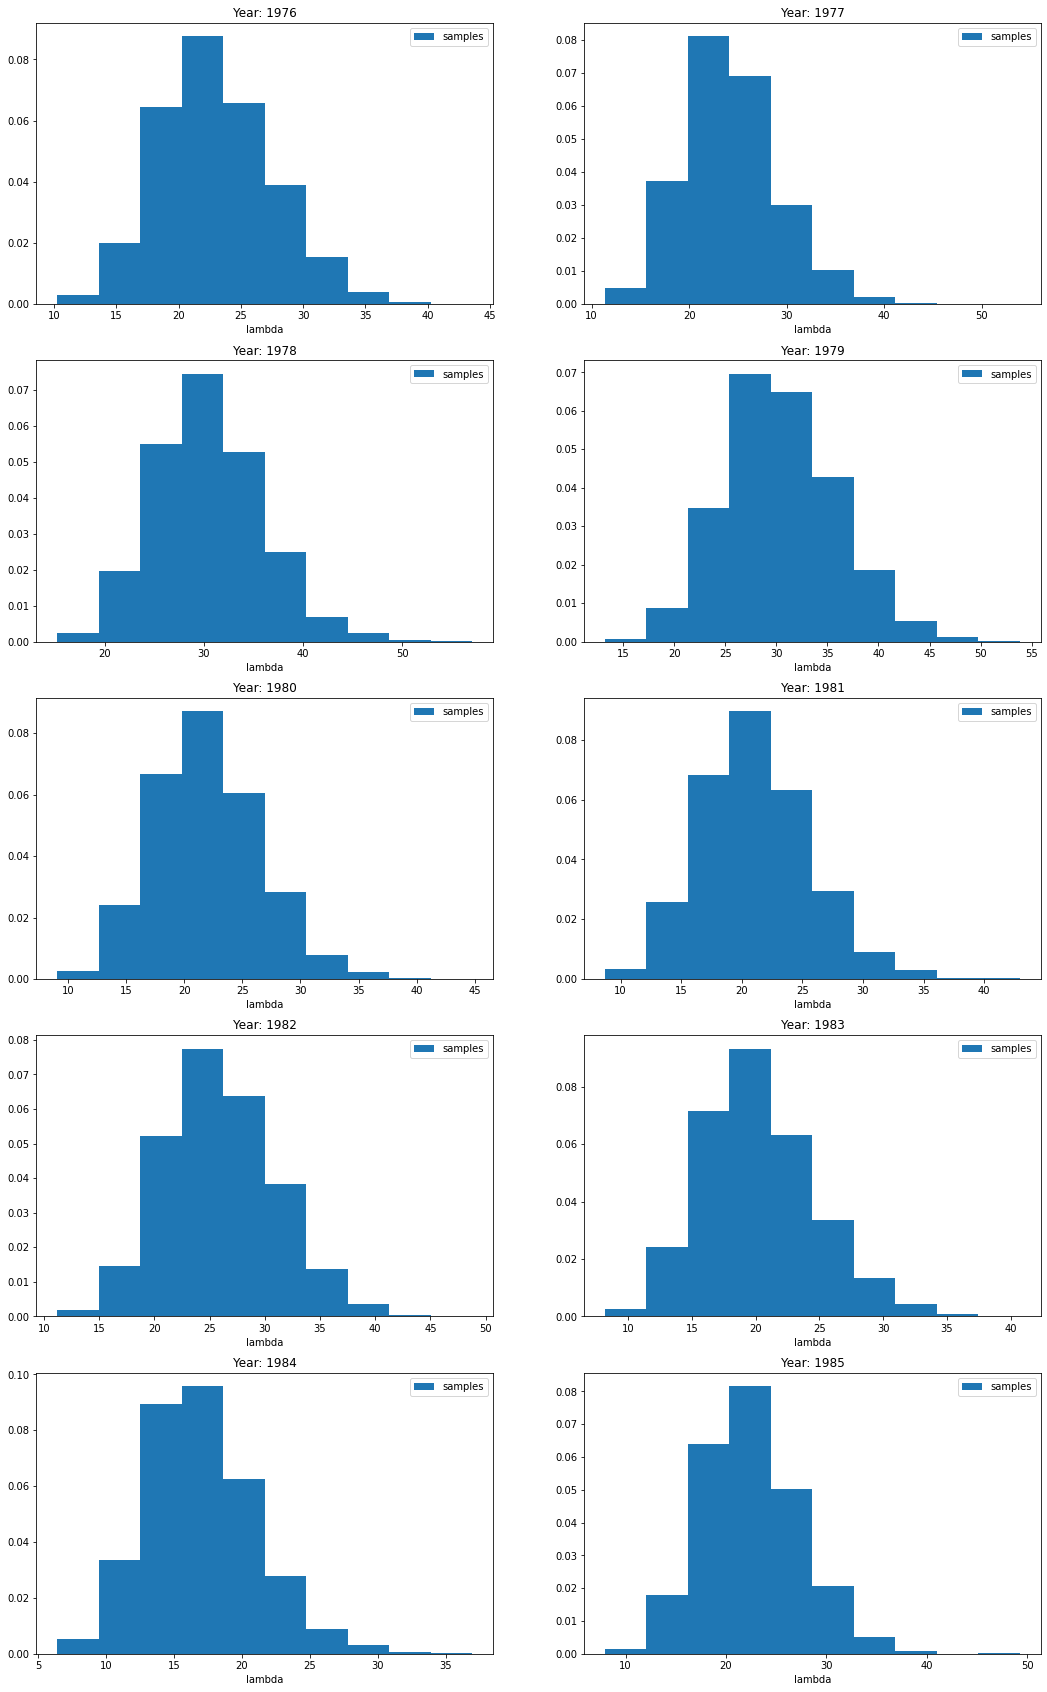

In [21]:
fig, axes = plt.subplots(int(len(df)/2), 2, figsize=(18, 30))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.hist(sampled_lambdas[f'lambda[{i + 1}]'].values, density=True, label='samples')
    ax.set_xlabel('lambda')
    ax.set_title(f'Year: {years[i]}')
    ax.legend()